# Writing Our Own Neural Network

We'll apply the ideas we just learned to a neural network that does character recognition using the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database#:~:text=The%20MNIST%20database%20(Modified%20National,the%20field%20of%20machine%20learning.).  This
is a set of handwritten digits (0&ndash;9) represented as a 28&times;28 pixel grayscale image.

There are 2 datasets, the training set with 60,000 images and the test set with 10,000 images.  We will use a version of the data that is provided as CSV files:

* [mnist_train.csv](mnist_train.csv)
* [mnist_test.csv](mnist_test.csv)

Each line of these files provides the answer (i.e., what the digit is) as the first column and then the next 784 columns are the pixel values.

We'll write a class to managed this data:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

A `TrainingDigit` provides a scaled floating point representation of the image as a 1D array (`.scaled`) as well as the correct answer (`.num`)
and categorical data that is used to represent the answer from the neural network&mdash;a 10 element array of 1s and 0s.  It also provides a method to plot the data.

In [76]:
class TrainingDigit:
    """a handwritten digit from the MNIST training set"""

    def __init__(self, raw_string):
        """we feed this a single line from the MNIST data set"""
        self.raw_string = raw_string

        # make the data range from 0.01 to 1.00
        _tmp = raw_string.split(",")
        self.scaled = np.asfarray(_tmp[1:])/255.0 * 0.99 + 0.01

        # the correct answer
        self.num = int(_tmp[0])

        # the output for the NN as a bit array -- make this lie in [0.01, 0.99]
        self.out = np.zeros(10) + 0.01
        self.out[self.num] = 0.99

    def plot(self, output=None):
        """plot the digit"""
        fig, ax = plt.subplots()
        ax.imshow(self.scaled.reshape((28, 28)),
                  cmap="Greys", interpolation="nearest")
        if output is not None:
            dstr = [f"{n}: {v:6.4f}" for n, v in enumerate(output)]
            ostr = f"correct digit: {self.num}\n"
            ostr += "  ".join(dstr[0:5]) + "\n" + "  ".join(dstr[5:])
            plt.title(f"{ostr}", fontsize="x-small")
        return fig

An `UnknownDigit` is like a `TrainingDigit` but it also provides a method to check if our prediction from the network is correct.

In [10]:
class UnknownDigit(TrainingDigit):
    """A digit from the MNIST test database.  This provides a method to
    compare a NN result to the correct answer

    """
    def __init__(self, raw_string):
        super().__init__(raw_string)
        self.out = None

    def check_output(self, out):
        """given the output array from the NN, return True if it is
        correct for this digit"""
        guess = np.argmax(out)
        return guess == self.num

Now we'll read in the data and store the training and test sets in separate lists

In [65]:
training_set = []
with open("mnist_train.csv") as f:
    for line in f:
        training_set.append(TrainingDigit(line))

In [66]:
len(training_set)

60000

In [68]:
test_set = []
with open("mnist_test.csv") as f:
    for line in f:
        test_set.append(UnknownDigit(line))

In [77]:
len(test_set)

10000

Let's look at the first digit in the training set

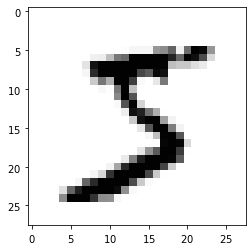

In [78]:
fig = training_set[0].plot()

Here's what the scaled pixel values look like&mdash;this is what will be fed into the network as input

In [79]:
training_set[0].scaled

array([0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01   

and here's what the categorical output looks like&mdash;this will be what we expect the network to return

In [80]:
training_set[0].out

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01])

Now we can write our neural network class.  We will include a single hidden layer.

In [64]:
class NeuralNetwork:
    """A neural network class with a single hidden layer."""

    def __init__(self, input_size=1, output_size=1, hidden_layer_size=1):

        # the number of nodes/neurons on the output layer
        self.m = output_size

        # the number of nodes/neurons on the input layer
        self.n = input_size

        # the number of nodes/neurons on the hidden layer
        self.k = hidden_layer_size

        # we will initialize the weights with Gaussian normal random
        # numbers centered on 0 with a width of 1/sqrt(n), where n is
        # the length of the input state

        # A is the set of weights between the hidden layer and output layer
        self.A = np.random.normal(0.0, 1.0/np.sqrt(self.k), (self.m, self.k))

        # B is the set of weights between the input layer and hidden layer
        self.B = np.random.normal(0.0, 1.0/np.sqrt(self.n), (self.k, self.n))

    def g(self, p):
        """our sigmoid function that operates on the hidden layer"""
        return 1.0/(1.0 + np.exp(-p))

    def train(self, training_data, n_epochs=1, learning_rate=0.1):
        """Train the neural network by doing gradient descent with back
        propagation to set the matrix elements in B (the weights
        between the input and hidden layer) and A (the weights between
        the hidden layer and output layer)

        """

        print(f"size of training data = {len(training_data)}")
        
        for i in range(n_epochs):
            print(f"epoch {i+1} of {n_epochs}")

            for n, model in enumerate(training_data):

                # make the input and output data one-dimensional
                x = model.scaled.reshape(self.n, 1)
                y = model.out.reshape(self.m, 1)

                # propagate the input through the network
                z_tilde = self.g(self.B @ x)
                z = self.g(self.A @ z_tilde)

                # compute the errors (backpropagate to the hidden layer)
                e = z - y
                e_tilde = self.A.T @ e

                # corrections
                dA = -2 * learning_rate * e * z*(1-z) @ z_tilde.T
                dB = -2 * learning_rate * e_tilde * z_tilde*(1-z_tilde) @ x.T

                self.A[:, :] += dA
                self.B[:, :] += dB

    def predict(self, model):
        """ predict the outcome using our trained matrix A """
        y = self.g(self.A @ (self.g(self.B @ model.scaled)))
        return y

Create our neural network

In [71]:
input_size = len(training_set[0].scaled)
output_size = len(training_set[0].out)
net = NeuralNetwork(input_size=input_size, output_size=output_size, hidden_layer_size=50)

Now we can train

In [73]:
net.train(training_set, n_epochs=5)

size of training data = 60000
epoch 1 of 5
epoch 2 of 5
epoch 3 of 5
epoch 4 of 5
epoch 5 of 5


Let's see what our accuracy rate is

In [82]:
n_correct = 0
for model in test_set:
    res = net.predict(model)
    if model.check_output(res):
        n_correct += 1

print(f"accuracy is {n_correct / len(test_set)}")

accuracy is 0.9465
